## General Steps

1) Load libraries
2) Load Data
3) Clean Data
4) Explore Data
5) Define What Models Could Be Used
6) Split Data
7) Preprocess: enconde, scale, transform
8) Train Models
9) Test Models
10) Support Graphs (Residuals)
11) Model Selection


## Load Libraries

In [48]:
# Loading libraries for handling data and graphs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.plotting import scatter_matrix 

# Loading libraries for modeling purposes
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score
from xgboost import XGBRegressor

## Load Data

In [26]:
# Load data
policies = pd.read_csv('policies.csv')
claims = pd.read_csv('claims.csv')

In [14]:
policies_duplicated_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Policy_ID        10000 non-null  int64  
 1   Customer_ID      10000 non-null  int64  
 2   Policy_Age       10000 non-null  int64  
 3   Product_Type     10000 non-null  object 
 4   Vehicle_Type     10000 non-null  object 
 5   Driving_History  10000 non-null  int64  
 6   Region           10000 non-null  object 
 7   Exposure         10000 non-null  int64  
 8   Premium          10000 non-null  float64
 9   Earned_Premium   10000 non-null  float64
 10  Ultimate_Losses  10000 non-null  float64
 11  Pure_Premium     10000 non-null  float64
 12  Reserved_Losses  10000 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 1.1+ MB


## Clean Data

In [15]:
# Clean data
#   1) Clean duplicates
#   2) Clean NaN

# Duplicates
policies_duplicated = sum(policies.duplicated())
print(f'Duplicated Records: {policies_duplicated}')

policies_duplicated_clean = policies.copy()
policies_duplicated_clean.drop_duplicates(keep='first', inplace=True)

print(f'Records before cleaning:{len(policies)}')
print(f'Records AFTER cleaning: {len(policies_duplicated_clean)}')


Duplicated Records: 50
Records before cleaning:10050
Records AFTER cleaning: 10000


In [16]:
# Check NaNs
policies_duplicated_clean.isnull().sum()


Policy_ID            0
Customer_ID          0
Policy_Age           0
Product_Type         0
Vehicle_Type         0
Driving_History      0
Region               0
Exposure             0
Premium              0
Earned_Premium       0
Ultimate_Losses      0
Pure_Premium         0
Reserved_Losses    100
dtype: int64

In [ ]:
# Clean NaNs
reserved_losses_median = policies_duplicated_clean['Reserved_Losses'].median()
policies_duplicated_clean['Reserved_Losses'].fillna(reserved_losses_median, inplace=True)
policies_duplicated_clean.isnull().sum()


Policy_ID          0
Customer_ID        0
Policy_Age         0
Product_Type       0
Vehicle_Type       0
Driving_History    0
Region             0
Exposure           0
Premium            0
Earned_Premium     0
Ultimate_Losses    0
Pure_Premium       0
Reserved_Losses    0
dtype: int64

## Explore Data

### Summarize Data

In [18]:
# Explore Data
policies_duplicated_clean.describe()

,Policy_ID,Customer_ID,Policy_Age,Driving_History,Exposure,Premium,Earned_Premium,Ultimate_Losses,Pure_Premium,Reserved_Losses
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,2522.052500,15.148100,0.501000,16.148100,754.006230,754.006230,982.477053,61.654003,779.889786
std,2886.89568,1438.434662,8.846129,0.717949,8.846129,147.567208,147.567208,1431.221719,73.268343,1137.548379
min,1.00000,2.000000,0.000000,0.000000,1.000000,323.340000,323.340000,0.000000,0.000000,0.000000
25%,2500.75000,1263.000000,7.000000,0.000000,8.000000,649.347500,649.347500,0.000000,0.000000,0.000000
50%,5000.50000,2548.500000,15.000000,0.000000,16.000000,743.315000,743.315000,381.100000,36.856596,305.105000
75%,7500.25000,3763.000000,23.000000,1.000000,24.000000,847.700000,847.700000,1411.645000,99.119932,1109.960000
max,10000.00000,4999.000000,30.000000,5.000000,31.000000,1398.810000,1398.810000,12823.260000,502.411693,10258.610000


In [38]:
summary_policies = policies_duplicated_clean.groupby(['Region', 'Product_Type']).agg(
    Ultimate_Losses_Count=pd.NamedAgg(column='Ultimate_Losses', aggfunc='count'),
    Ultimate_Losses_Total=pd.NamedAgg(column='Ultimate_Losses', aggfunc='sum'),
    Ultimate_Losses_Min=pd.NamedAgg(column='Ultimate_Losses', aggfunc='min'),
    Ultimate_Losses_Mean=pd.NamedAgg(column='Ultimate_Losses', aggfunc='mean'),
    Ultimate_losses_Max=pd.NamedAgg(column='Ultimate_Losses', aggfunc='max'),
    Policy_Age_Avg=pd.NamedAgg(column='Policy_Age', aggfunc='mean'),
    Driving_History_Avg=pd.NamedAgg(column='Driving_History', aggfunc='mean'),
    Pure_Premium_Min=pd.NamedAgg(column='Pure_Premium', aggfunc='min'),
    Pure_Premium_Mean=pd.NamedAgg(column='Pure_Premium', aggfunc='mean'),
    Pure_Premium_Max=pd.NamedAgg(column='Pure_Premium', aggfunc='max')
).reset_index()

# Claims
#   - For each Claim Type calculate:
#       - Claim Amount the min, mean and max
#       - Severity min, mean and max

summary_claims = claims.groupby('Claim_Type').agg(
    Claim_Amount_Count=pd.NamedAgg(column='Claim_Amount', aggfunc='count'),
    Claim_Amount_Total=pd.NamedAgg(column='Claim_Amount', aggfunc='sum'),
    Claim_Amount_Minimum=pd.NamedAgg(column='Claim_Amount', aggfunc='min'),
    Claim_Amount_Mean=pd.NamedAgg(column='Claim_Amount', aggfunc='mean'),
    Claim_Amount_Maximum=pd.NamedAgg(column='Claim_Amount', aggfunc='max'),
    Severity_Minimum=pd.NamedAgg(column='Severity', aggfunc='min'),
    Severity_Mean=pd.NamedAgg(column='Severity', aggfunc='mean'),
    Severity_Maximum=pd.NamedAgg(column='Severity', aggfunc='max')
).reset_index()

In [39]:
summary_policies

,Region,Product_Type,Ultimate_Losses_Count,Ultimate_Losses_Total,Ultimate_Losses_Min,Ultimate_Losses_Mean,Ultimate_losses_Max,Policy_Age_Avg,Driving_History_Avg,Pure_Premium_Min,Pure_Premium_Mean,Pure_Premium_Max
0,Midwest,Auto,390,395045.60,0.0,1012.937436,8531.38,15.089744,0.487179,0.0,61.975117,426.568934
1,Midwest,BOP,473,478042.25,0.0,1010.660148,7018.60,15.143763,0.583510,0.0,65.234018,365.900403
2,Midwest,Home,599,632577.00,0.0,1056.055092,10880.49,15.166945,0.539232,0.0,65.702003,471.214113
3,Midwest,Liability,660,640960.49,0.0,971.152258,11875.04,15.015152,0.487879,0.0,59.072460,424.108564
4,Midwest,Transportation,393,457538.84,0.0,1164.220967,9699.37,15.206107,0.603053,0.0,71.899457,400.624847
5,Northeast,Auto,364,365172.08,0.0,1003.220000,8708.27,14.494505,0.521978,0.0,67.643892,322.470896
6,Northeast,BOP,502,518511.07,0.0,1032.890578,12489.49,15.685259,0.527888,0.0,62.491562,462.573837
7,Northeast,Home,591,568179.51,0.0,961.386650,11555.47,15.426396,0.458545,0.0,58.358187,502.411693
8,Northeast,Liability,613,588836.04,0.0,960.580816,8776.13,14.698206,0.502447,0.0,61.509228,432.567470
9,Northeast,Transportation,371,319410.23,0.0,860.944016,7074.69,15.177898,0.450135,0.0,54.273441,338.255124


In [40]:
summary_claims

,Claim_Type,Claim_Amount_Count,Claim_Amount_Total,Claim_Amount_Minimum,Claim_Amount_Mean,Claim_Amount_Maximum,Severity_Minimum,Severity_Mean,Severity_Maximum
0,Bodily Injury,871,66809.28,0.0,76.704110,517.42,0.0,76.645605,517.42
1,Collision,608,42885.52,0.0,70.535395,461.62,0.0,70.502471,461.62
2,Comprehensive,288,20185.45,0.0,70.088368,599.21,0.0,69.908351,599.21
3,Property Damage,1172,86711.57,0.0,73.985981,638.48,0.0,74.303752,638.48


### Create Charts for Supporting the Analysis

array([[<AxesSubplot:title={'center':'Policy_ID'}>,
        <AxesSubplot:title={'center':'Customer_ID'}>,
        <AxesSubplot:title={'center':'Policy_Age'}>],
       [<AxesSubplot:title={'center':'Driving_History'}>,
        <AxesSubplot:title={'center':'Exposure'}>,
        <AxesSubplot:title={'center':'Premium'}>],
       [<AxesSubplot:title={'center':'Earned_Premium'}>,
        <AxesSubplot:title={'center':'Ultimate_Losses'}>,
        <AxesSubplot:title={'center':'Pure_Premium'}>],
       [<AxesSubplot:title={'center':'Reserved_Losses'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

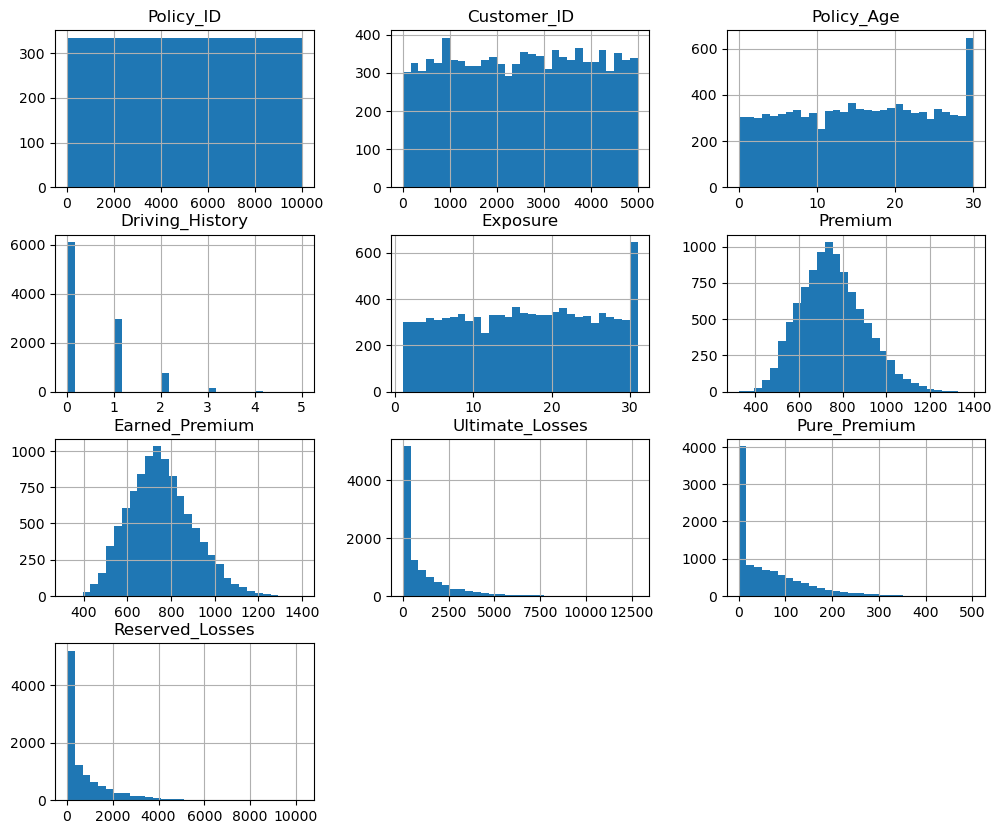

In [ ]:
# Distributions
policies_duplicated_clean.hist(bins=30, figsize=(12, 10))

In [ ]:
# Correlation 
correlation_matrix=policies_duplicated_clean.corr()
print(correlation_matrix['Pure_Premium'].sort_values(ascending=False))


Pure_Premium       1.000000
Driving_History    0.854224
Ultimate_Losses    0.806600
Reserved_Losses    0.800783
Premium            0.186230
Earned_Premium     0.186230
Policy_ID          0.011021
Customer_ID        0.008643
Policy_Age        -0.020241
Exposure          -0.020241
Name: Pure_Premium, dtype: float64


array([[<AxesSubplot:xlabel='Pure_Premium', ylabel='Pure_Premium'>,
        <AxesSubplot:xlabel='Driving_History', ylabel='Pure_Premium'>,
        <AxesSubplot:xlabel='Ultimate_Losses', ylabel='Pure_Premium'>,
        <AxesSubplot:xlabel='Reserved_Losses', ylabel='Pure_Premium'>,
        <AxesSubplot:xlabel='Premium', ylabel='Pure_Premium'>,
        <AxesSubplot:xlabel='Earned_Premium', ylabel='Pure_Premium'>],
       [<AxesSubplot:xlabel='Pure_Premium', ylabel='Driving_History'>,
        <AxesSubplot:xlabel='Driving_History', ylabel='Driving_History'>,
        <AxesSubplot:xlabel='Ultimate_Losses', ylabel='Driving_History'>,
        <AxesSubplot:xlabel='Reserved_Losses', ylabel='Driving_History'>,
        <AxesSubplot:xlabel='Premium', ylabel='Driving_History'>,
        <AxesSubplot:xlabel='Earned_Premium', ylabel='Driving_History'>],
       [<AxesSubplot:xlabel='Pure_Premium', ylabel='Ultimate_Losses'>,
        <AxesSubplot:xlabel='Driving_History', ylabel='Ultimate_Losses'>,
       

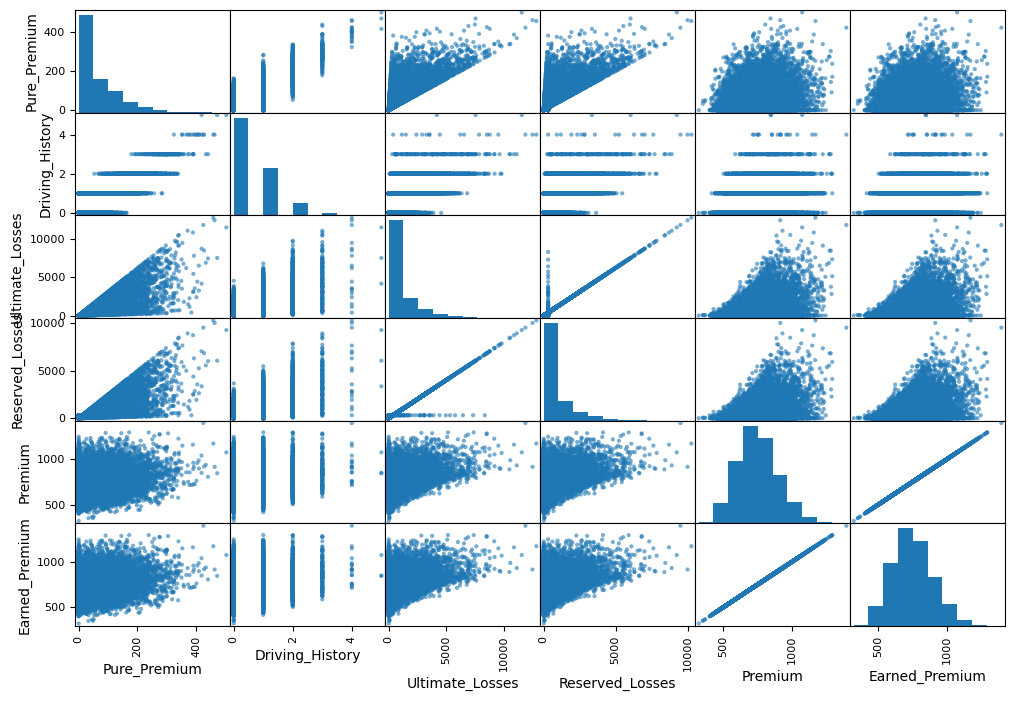

In [25]:
# Focus on main attributes
main_attributes = ['Pure_Premium', 'Driving_History', 'Ultimate_Losses', 'Reserved_Losses', 'Premium', 'Earned_Premium']
scatter_matrix(policies_duplicated_clean[main_attributes], alpha=0.6, figsize=(12, 8))

## Define Modeling Apporches:

* Continuous regression problem

* Linear Regresion Model

* Gradiente Boosting Machine (XGBoost)

## Select Features and Split Data

In [41]:
policies_duplicated_clean.columns

Index(['Policy_ID', 'Customer_ID', 'Policy_Age', 'Product_Type',
       'Vehicle_Type', 'Driving_History', 'Region', 'Exposure', 'Premium',
       'Earned_Premium', 'Ultimate_Losses', 'Pure_Premium', 'Reserved_Losses'],
      dtype='object')

In [44]:
# Select features
features = ['Policy_Age', 'Product_Type', 'Vehicle_Type', 'Driving_History', 'Region']
target = 'Pure_Premium'

X = policies_duplicated_clean[features]
y = policies_duplicated_clean[target]


## Preprocess: encode, transform and scale

In [49]:
# Encode features
encoder = OneHotEncoder(drop='first', sparse=False)

column_transformer = ColumnTransformer(
    transformers=[
        ('onehot', encoder, ['Product_Type', 'Vehicle_Type', 'Region'])
    ],
    remainder='passthrough'
)

# Transform
X_encoded = column_transformer.fit_transform(X)

encoded_feature_names = column_transformer.named_transformers_['onehot'].get_feature_names_out(['Product_Type', 'Vehicle_Type', 'Region'])

final_feature_names = list(encoded_feature_names) + ['Policy_Age', 'Driving_History']
X_combined = pd.DataFrame(X_encoded, columns=final_feature_names)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# Scale

scaling_pipeline = Pipeline([('scaler', StandardScaler())])

X_train_scaled = scaling_pipeline.fit_transform(X_train)
X_test_scaled = scaling_pipeline.transform(X_test)


## Train and Test Models

In [53]:
#### Model 1: Linear Regression Model ####
# Train model
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

# Crete predictions
y_pred_lm = lm.predict(X_test_scaled)

# Evaluate
rmse_lm = np.sqrt(mean_squared_error(y_test, y_pred_lm))
mae_lm = mean_absolute_error(y_test, y_pred_lm)
expv_lm = explained_variance_score(y_test, y_pred_lm)

#### Model 2: Gradient Boosting Machine (XGBoost) ####
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train_scaled, y_train)

# Create predictions
y_pred_xgb = xgb.predict(X_test_scaled)

# Evaluate
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
expv_xgb = explained_variance_score(y_test, y_pred_xgb)


# Present metrics using a dictionary fromated as a df to store metrics' names and values
comparison = pd.DataFrame({
    'Model': ['Linear Model', 'XGBoost'],
    'RMSE': [rmse_lm, rmse_xgb],
    'MAE' : [mae_lm, mae_xgb],
    'Explained Variance' : [expv_lm, expv_xgb]
})

comparison


,Model,RMSE,MAE,Explained Variance
0,Linear Model,38.424977,29.593820,0.730850
1,XGBoost,39.022755,30.097457,0.722424


## Support Graphs

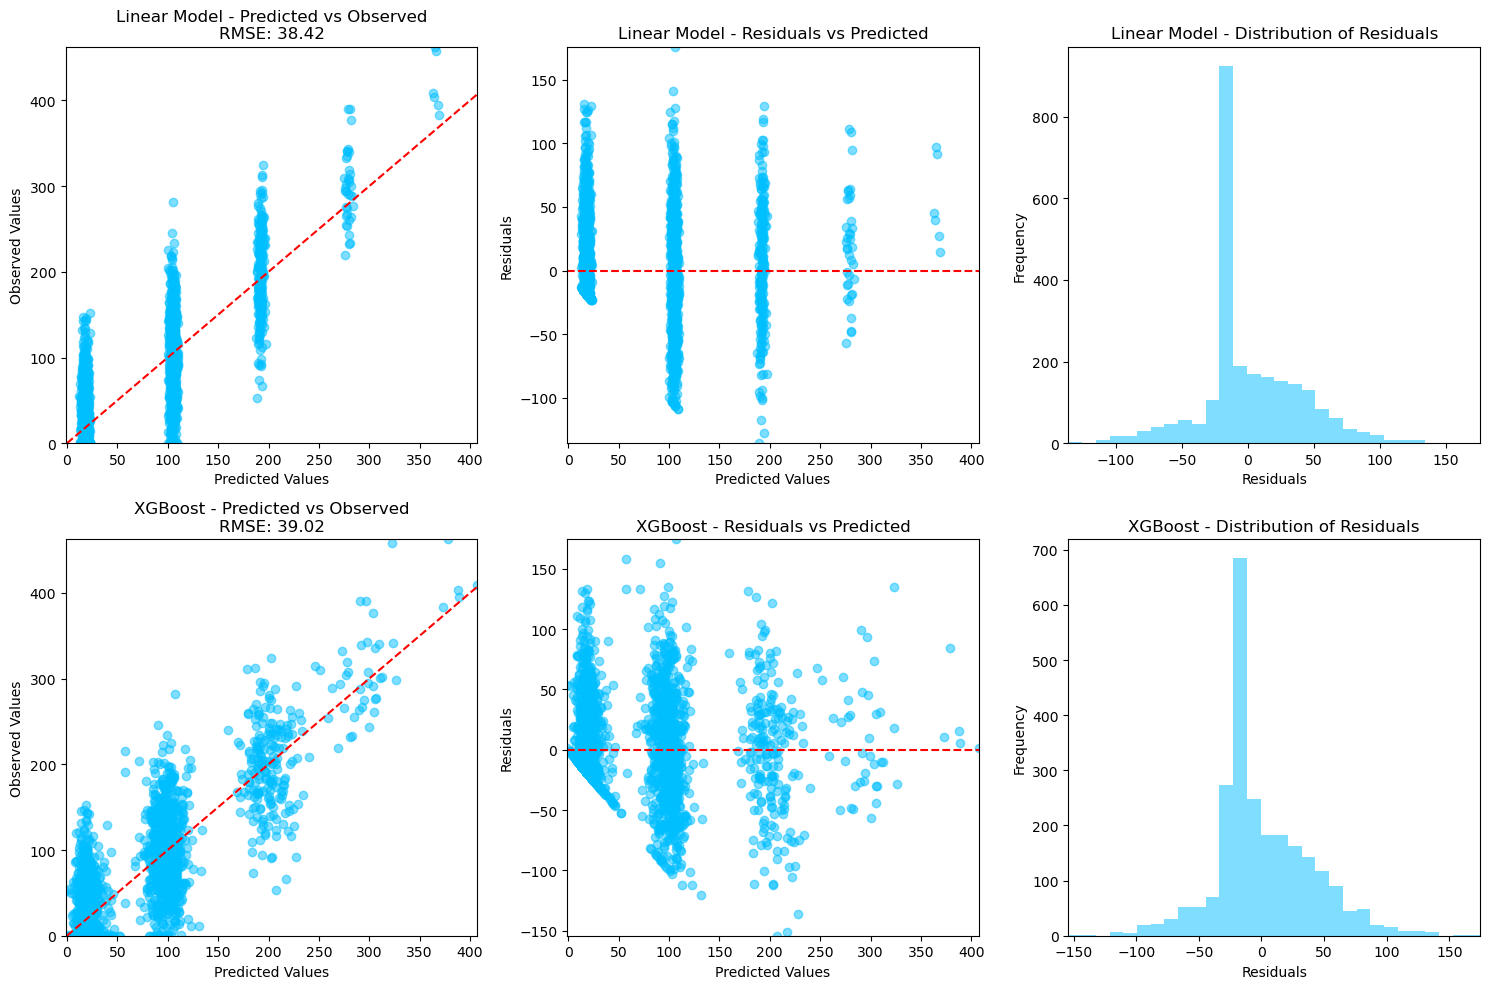

In [54]:
# List of models and predictions
models = ['Linear Model', 'XGBoost']
predictions = [y_pred_lm, y_pred_xgb]

# Calculate global limits for Predicted vs Observed and Residuals vs Predicted plots
y_min, y_max = y_test.min(), y_test.max()
pred_min, pred_max = min([y_pred.min() for y_pred in predictions]), max([y_pred.max() for y_pred in predictions])

# Create subplots for all models
fig, axes = plt.subplots(len(models), 3, figsize=(15, 5 * len(models)))  # Rows = # models, Columns = 3

# Loop through each model
colors = ['deepskyblue', 'deepskyblue', 'deepskyblue']
for i, (model, y_pred, color) in enumerate(zip(models, predictions, colors)):
    residuals = y_test - y_pred

    # Predicted vs Observed
    axes[i, 0].scatter(x=y_pred, y=y_test, alpha=0.5, color=color)
    axes[i, 0].plot([y_min, y_max], [y_min, y_max], color='red', linestyle='--')
    axes[i, 0].set_title(f'{model} - Predicted vs Observed\nRMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}')
    axes[i, 0].set_xlabel('Predicted Values')
    axes[i, 0].set_ylabel('Observed Values')
    axes[i, 0].set_xlim(pred_min, pred_max)
    axes[i, 0].set_ylim(y_min, y_max)

    # Residuals vs Predicted
    axes[i, 1].scatter(y_pred, residuals, alpha=0.5, color=color)
    axes[i, 1].axhline(0, color='red', linestyle='--')
    axes[i, 1].set_title(f'{model} - Residuals vs Predicted')
    axes[i, 1].set_xlabel('Predicted Values')
    axes[i, 1].set_ylabel('Residuals')
    axes[i, 1].set_xlim(pred_min, pred_max)
    axes[i, 1].set_ylim(residuals.min(), residuals.max()) 

    # Distribution of Residuals
    axes[i, 2].hist(residuals, bins=30, alpha=0.5, color=color)
    axes[i, 2].set_title(f'{model} - Distribution of Residuals')
    axes[i, 2].set_xlabel('Residuals')
    axes[i, 2].set_ylabel('Frequency')
    axes[i, 2].set_xlim(residuals.min(), residuals.max())

# Adjust layout and show plots
plt.tight_layout()
plt.show()
